# OPManalysis - Example of OPM Data Analysis

This notebook demonstrates how to:

- Load experimental **Optically Pumped Magnetometers(OPMs)** data
- Extract one complete magnetic field sweep cycle
- Fit the demodulated signal using Lorentzian, Gaussian, or linear models for different analysis purposes
- Analyze noise using power spectral density (PSD)
- The demonstration dataset was acquired using **Moku:Pro (Liquid Instruments)**


If the package is not installed yet, install it with:

In [ ]:
pip install git+https://github.com/yschen222/OPManalysis

## Introduction to Experimental Setup

<img src="images/fig1.png" alt="Setup" width="400"/>

This schematic shows the experimental configuration for OPM signal acquisition.  
The red beam (pump laser) propagates along the x-axis, while the modulated magnetic field is applied along the z-axis.

A modulation signal (from Moku:Pro LIA mode) and a triangular ramp function (from Moku:Pro FG mode) are combined via a bias tee and sent to the internal z-coil inside the magnetic shielding.  
The triangular ramp sweeps the background magnetic field, enabling field-resolved signal measurements.

We record three signals:
- The raw signal from the photodetector (absorption)
- The demodulated signal from the lock-in amplifier (dispersion)
- The triangle wave that appended to magnetic field 

These three signals are essential for accurate data analysis.

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from opmtool import (
        lorentz_fit, gauss_fit, voigt_fit, asymmetric_lorentz_fit, dispersion_lorentz_fit, 
        one_cycle_cut, noise_psd, noise_psd_lowband
    )

## Data Import and Processing — Half-Cycle Extraction

We use a demo dataset from an OPM experiment recorded by **Moku:Pro**.  
📂 Raw `.csv` files are placed in `examples/Demo_data` for testing and demonstration.

This dataset contains four columns:
- **`time`** (`t`): sampling time axis  
- **`Ab`**: absorption signal from the photodetector  
- **`demod`**: lock-in (LIA) demodulated signal from Moku:Pro  
- **`tri`**: the **measured** triangle/sawtooth magnetic-field drive (required for robust cutting)

Acquisition used a triangle/sawtooth magnetic modulation with a sweep amplitude of **±34 nT** and a frequency of **0.5 Hz**.

---

### Isolating a Single Half-Cycle

Because each recording may include multiple ramps and can be **rising-only** or **falling-only**, we isolate exactly **one half-cycle** directly from the **measured triangle waveform** and map it to the magnetic-field axis.  
This avoids boundary errors that arise if one tries to infer sweep limits from the absorption line shape.

We provide the function **`one_cycle_cut`** to do this.

---

### `one_cycle_cut(data, B_range, ..., segment='half')`

**Purpose:**  
Extract **one monotonic ramp** (rising *or* falling) from the measured triangle/sawtooth and convert it to a magnetic-field axis within the specified range.

**Inputs (key parameters):**
- **`data`** *(DataFrame or ndarray)*  
  DataFrame must contain columns `[time, Ab, demod, tri]` (names configurable).  
  ndarray must be shape `(N, 4)` with columns `[t, Ab, demod, tri]` in that order.

- **`B_range`** *(tuple of float)*  
  The commanded sweep limits `(B_min, B_max)`, e.g. `(-34, 34)` in nT.

- **`segment='half'`**  
  Selects a **single half-cycle** (strictly monotonic ramp).  
  > Use `'full'` only if you need one rise+fall cycle; half-cycle is recommended when your data are rising-only or falling-only.

- **`direction`** *{`'auto'`, `'rising'`, `'falling'`}*  
  Which half-cycle to cut:  
  - `'rising'`: min→max (increasing triangle)  
  - `'falling'`: max→min (decreasing triangle)  
  - `'auto'`: inferred from triangle derivative distribution

- **`cycles=1`**  
  Number of **consecutive half-cycles** to stitch (keep `1` to extract exactly one).

- **`time_col`, `ab_col`, `demod_col`, `tri_col`** *(str)*  
  Column names when `data` is a DataFrame. `tri_col` is **required**.

- **`smooth_win=5`**  
  Small moving-average (in samples) applied to the triangle for robust segmentation.  
  Use a small odd integer (e.g., 3–7). Set ≤1 to disable.

- **`anchor`** *{`'abspeak'`, `'center'`, `'first'`, `'last'`}*  
  How to choose the **starting** half-cycle before stitching `cycles`:  
  - `'abspeak'` (default): segment containing the largest \|Ab − baseline\| peak  
  - `'center'`: segment closest to the middle of the record  
  - `'first'` / `'last'`: earliest / latest valid segment

- **`edge_clip_frac=0.02`**  
  Trim **2%** off both ends of the chosen segment to avoid turn-around artifacts and coil dynamics.  
  This removes edge **samples** but does not change how the sweep limits are defined.

- **`map_mode='global'` (default)**  
  Field mapping uses the **pre-clip** min/max of the selected triangle segment(s).  
  Effect: after clipping, the resulting `BField` remains **strictly within** the requested range (e.g., ±34 nT) and typically **does not touch** the endpoints.  
  > If you want the clipped data to be stretched back to fill the full range, set `map_mode='local'` (not recommended for typical analysis).

- **`require_tri=True`**  
  Enforce the presence of the triangle column; prevents fallback to unreliable heuristics.

- **`return_debug=False`**  
  If `True`, also returns a dictionary with segmentation details (indices, spans, detected direction).

**Outputs:**
- **`BField`** *(ndarray)* — magnetic-field axis in the same units as `B_range` (e.g., nT)  
- **`AbCut`** *(ndarray)* — absorption signal for the selected half-cycle  
- **`DemodCut`** *(ndarray)* — demodulated (LIA) signal for the same half-cycle  
- **`debug`** *(dict, optional)* — segmentation diagnostics (`direction`, `runs`, chosen indices pre/post clip, triangle spans, `map_mode`)

---

### Practical Notes

- **Triangle-driven segmentation:** Boundaries are defined by the **drive** (`tri`), not by absorption peaks/valleys—this is more robust for asymmetric line shapes and finite coil/LIA dynamics.  
- **Keep `map_mode='global'`:** Ensures your `BField` stays *inside* the specified ±range after trimming (no artificial “stretch back”).  
- **Direction matters:** Match `direction` to your acquisition (rising vs. falling). If unsure, use `'auto'` and verify quickly with a plot.  
- **Smoothing & clipping:** If a half-cycle appears fragmented, slightly **increase** `smooth_win` or **decrease** `edge_clip_frac`.  
- **Downstream fitting:** After cutting a clean half-cycle, apply your chosen line-shape fit (`voigt_fit`, `gauss_fit`, or `lorentz_fit`) to extract FWHM and other parameters for sensitivity/relaxation analysis.

In [ ]:
# === Data import ===

# Automatically detect the current notebook folder
thisdir = os.path.dirname(__file__) if '__file__' in globals() else os.getcwd()

# Relative path to the demo data folder
folder = os.path.join(thisdir, "Demo_data")

# 📌 If you're using your own data, modify the path like this:
# folder = r"C:\Users\YourName\Path\To\Your\Own\Data"

# Recursively search for all .csv files
all_csv_files = glob.glob(os.path.join(folder, "**", "*.csv"), recursive=True)

# Automatically classify data and noise files
data_files  = [f for f in all_csv_files if "noise" not in f.lower()]
noise_files = [f for f in all_csv_files if "noise" in f.lower()]

# Load the first matched pair
FILE      = data_files[0]
noiseFILE = noise_files[0]

# Read in data
df        = pd.read_csv(FILE, skiprows=21, names=['time','Ab','demod','tri'])
noisedata = pd.read_csv(noiseFILE, skiprows=21, names=['t','signal1','signal2','signal3'])

# Confirm loaded file paths
print("✅ Loaded signal file:", FILE)
print("✅ Loaded noise file:",  noiseFILE)

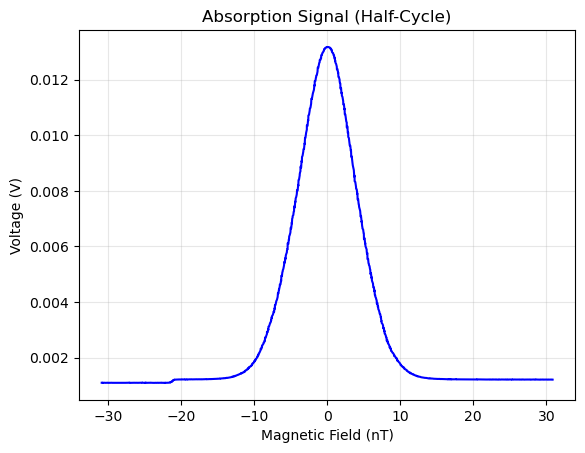

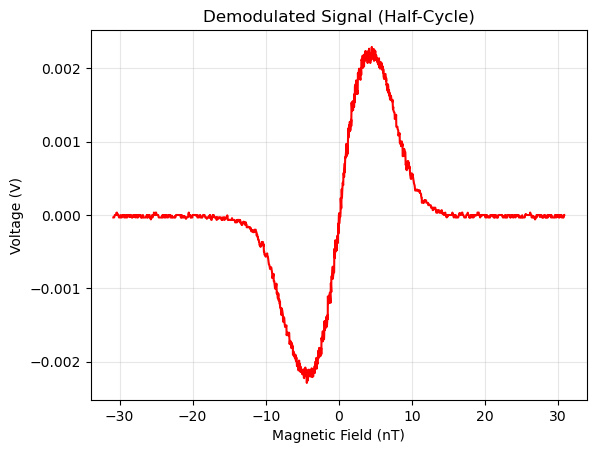

In [3]:
# Data processing (half-cycle cut with measured triangle)
# Requires df to contain columns: ['time', 'Ab', 'demod', 'tri']
# --- Cut exactly one half-cycle and map to magnetic field ---
B, AbCut, DemodCut = one_cycle_cut(
    df,
    B_range=(-32.12, 32.12),     # commanded sweep range in nT
    segment='half',        # half-cycle (rising-only or falling-only)
    direction='auto',      # 'rising'|'falling' or 'auto' to infer
    edge_clip_frac=0.02,   # trim 2% at both ends to avoid turn-around artifacts
    map_mode='global'      # keep B strictly within ±34 nT after clipping
)

# Stack for downstream use
data_ab    = np.column_stack((B, AbCut))
data_demod = np.column_stack((B, DemodCut))

# --- Absorption signal ---
plt.figure()
plt.plot(data_ab[:, 0], data_ab[:, 1], 'b')
plt.title("Absorption Signal (Half-Cycle)")
plt.xlabel("Magnetic Field (nT)")
plt.ylabel("Voltage (V)")
plt.grid(True, alpha=0.3)

# --- Demodulated signal ---
plt.figure()
plt.plot(data_demod[:, 0], data_demod[:, 1], 'r')
plt.title("Demodulated Signal (Half-Cycle)")
plt.xlabel("Magnetic Field (nT)")
plt.ylabel("Voltage (V)")
plt.grid(True, alpha=0.3)

plt.show()

## Absorption Signal Fitting: Gaussian, Lorentz, and Voigt Models

In OPMs, the magnetic-resonance linewidth is a key performance metric.  
Here we fit the **absorption** trace (`AbCut`) with **Lorentzian**, **Gaussian**, and **Voigt** models and report the **full width at half maximum (FWHM)** and **R²**.  
All fitters support **automatic** initialization (no user input) **or** **manual** seeding of initial guesses and parameter bounds.

---

### Models

- **Lorentzian (with center offset)**  
  $$
  f(B)=\frac{a}{1+\big[b\,(B-\mathrm{center})\big]^2}+c
  $$
  Parameters:  
  $a$ amplitude, $b$ width factor, $\mathrm{center}$ center, $c$ offset.  
  Conversions:  
  $$
  \mathrm{FWHM}_\mathrm{L}=\frac{2}{|b|},\qquad \gamma\ (\text{HWHM})=\frac{1}{|b|}
  $$

- **Gaussian**  
  $$
  f(B)=a\,\exp\!\left[-\frac{(B-\mu)^2}{2\sigma^2}\right]+c
  $$
  Parameters:  
  $a$ **area** (per `lmfit.GaussianModel`), $\mu$ center, $\sigma$ standard deviation, $c$ offset.  
  Conversions:  
  $$
  \mathrm{FWHM}_\mathrm{G}=2\sqrt{2\ln 2}\,\sigma,\qquad
  \text{peak height}=\frac{a}{\sqrt{2\pi}\,\sigma}
  $$

- **Voigt** (convolution of Gaussian and Lorentzian)  
  $$
  f(B)=c + A \cdot V_0(B - \mathrm{center};\ \sigma,\ \gamma)
  $$
  where $V_0$ is the **area-normalized Voigt profile** (via `scipy.special.voigt_profile`).  
  Parameters:  
  $A$ **area amplitude**, `center`, Gaussian width $\sigma$, Lorentzian HWHM $\gamma$, and offset $c$.  
  FWHM (Olivero–Longbothum approximation):  
  $$
  \mathrm{FWHM}\approx 0.5346\,\Gamma+\sqrt{0.2166\,\Gamma^2+G^2},\quad
  \Gamma=2\gamma,\ \ G=2\sqrt{2\ln2}\,\sigma
  $$
  *Use Voigt when your line is the result of **both** inhomogeneous (Gaussian) and homogeneous (Lorentzian) broadening.*

---

### Voigt Fitting Strategy: G/L Seed Approach

The **new `voigt_fit`** uses an intelligent seeding strategy:

1. **First**, fit both **Gaussian** and **Lorentzian** models independently using `scipy.optimize.curve_fit`.
2. **Select** the better-fitting model (higher R²) to inform the Voigt initial guess:
   - If **Gaussian** fits better → bias initial widths toward $\sigma$ (90% Gaussian, 10% Lorentzian)
   - If **Lorentzian** fits better → bias initial widths toward $\gamma$ (10% Gaussian, 90% Lorentzian)
3. **Fit Voigt** using `scipy.optimize.curve_fit` with these smart initial values.
4. **Optionally** perform **model selection** via **AIC/BIC** to determine which model (Gaussian/Lorentzian/Voigt) best describes your data.

This approach:
- ✅ Provides **robust automatic initialization** even for challenging lineshapes
- ✅ Avoids common convergence issues with naive Voigt seeds
- ✅ Offers **model comparison** to validate whether the added complexity of Voigt is justified

---

### Automatic vs. Manual Initialization

All three fitters accept optional **initial guesses** (`p0`) and **bounds**:

- **Automatic (`p0=None`)** — **strongly recommended first try**  
  The fitter will:
  1. Estimate a baseline from the **edges** (and optionally a light **linear** edge baseline).
  2. Locate a provisional **center** near the strongest excursion and **refine** it by a local quadratic fit.
  3. **(Voigt only)** Perform Gaussian and Lorentzian pre-fits to intelligently seed $\sigma$ and $\gamma$.
  4. Estimate a provisional **FWHM** from half-maximum crossings and convert it to $b$/\(\sigma\)/\((\sigma,\gamma)\).
  5. Set consistent **amplitude** and **offset**.

- **Manual (`p0` provided)** — for tighter control or difficult data  
  Supply a **dict** with any subset; missing values fall back to auto-estimates.

  **Lorentzian `lorentz_fit(data, p0, bounds)`**  
  - `p0` keys: `amplitude`, `center`, `offset`, and **one of** `b` **or** `gamma` **or** `FWHM`.  
    (Internally we convert `gamma`/`FWHM` → `b`.)  
  - Tuple form also supported: `(a, b, center, c)`.

  **Gaussian `gauss_fit(data, p0, bounds)`**  
  - `p0` keys: `amplitude` (**area**), `center`, `sigma`, `offset`.

  **Voigt `voigt_fit(data, p0, bounds, maxfev=30000, use_model_selection=True)`**  
  - `p0` keys: `amplitude` (**area**), `center`, `sigma`, `gamma`, `offset`.
  - `maxfev`: maximum function evaluations (default: 30000).
  - `use_model_selection`: if `True`, selects best model by AIC (default: `True`).

- **Bounds (`bounds` dict, optional)** — `(min, max)` per parameter  
  - **Lorentz:** `{'amplitude':(...), 'center':(...), 'offset':(...), 'b':(...)}`
    or use `gamma`/`FWHM` bounds (converted internally to `b` limits).  
  - **Gaussian:** `{'amplitude':(...), 'center':(...), 'sigma':(...), 'offset':(...)}`
  - **Voigt:** `{'amplitude':(...), 'center':(...), 'sigma':(...), 'gamma':(...), 'offset':(...)}`
  - Widths are enforced positive (`sigma>0`, `gamma>0`, `|b|>0`); if a `center` bound is not supplied, a sensible search window around the auto center is used.

---

### Return Structure

**Lorentzian and Gaussian** return a dictionary with:

- `out` — the `lmfit` result object  
- `S_fit` — fitted y-values on the input grid  
- `Params` — fitted parameters  
  - **Lorentz:** `{'amplitude', 'center', 'gamma', 'offset', 'b'}`  
  - **Gaussian:** `{'amplitude', 'center', 'sigma', 'offset'}`  
- `FWHM` — full width at half maximum  
- `sigma` / `gamma` — Gaussian $\sigma$ or Lorentzian $\gamma$ (non-applicable entries are `None`)  
- `Data` — input data with an added `S_fit` column  
- `R2` — coefficient of determination

**Voigt** returns an **extended** dictionary with:

- **Backward-compatible fields** (based on the selected best model):
  - `out` — dict mimicking lmfit structure with `best_fit` and `params`
  - `S_fit` — fitted y-values of the best model
  - `Params` — parameters of the best model
  - `FWHM`, `sigma`, `gamma` — from the best model
  - `R2` — coefficient of determination of the best model
  - `Data` — input data with `S_fit` column

- **New detailed fields**:
  - `Voigt` — dict with `{popt, pcov, yfit, Params, FWHM, FWHM_L, FWHM_G, R2}`
  - `Gaussian` — dict with `{popt, yfit, FWHM, R2}`
  - `Lorentzian` — dict with `{popt, yfit, FWHM, R2}`
  - `AIC_BIC` — model comparison metrics:
    - `AIC`: `{'G': ..., 'L': ..., 'V': ...}`
    - `BIC`: `{'G': ..., 'L': ..., 'V': ...}`
  - `ModelSelected` — `"Gaussian"` | `"Lorentzian"` | `"Voigt"` (based on lowest AIC)
  - `Data` — DataFrame with columns `Voigt_fit`, `Gauss_fit`, `Lorentz_fit`

---

### Practical Guidance

- **Start with automatic seeding** for all models; the new Voigt fitter is particularly robust thanks to G/L pre-fitting.
- If the center drifts or the width is unstable, provide a **manual** `center` plus a rough `sigma`/`gamma` (or `FWHM` for Lorentz) to stabilize.  
- **Check model selection**: if `voigt_result['ModelSelected']` returns `"Gaussian"` or `"Lorentzian"`, the simpler model may be sufficient (lower AIC = better parsimony).
- Remember: in both **Gaussian** and **Voigt**, `amplitude` is **area**, not peak height. Use the conversion if you think in heights.  
- Use **Voigt** when both broadening mechanisms are relevant, but if your goal is to extract **relaxation** from a purely homogeneous line, a Lorentzian is the cleanest route.  
- For mild baseline slopes, the built-in edge/linear baseline usually suffices; for strong drifts, pre-detrend before fitting.
- The **AIC/BIC comparison** helps avoid overfitting: Voigt has 5 parameters vs. 4 for Gaussian/Lorentzian, so the improvement in fit quality must justify the extra complexity.

---
### Technical Notes

- **Implementation**: The new Voigt fitter uses `scipy.optimize.curve_fit` with `scipy.special.voigt_profile` (area-normalized kernel), ensuring numerical stability and consistency with SciPy conventions.
- **Model selection**: AIC = $2k - 2\ln(L)$ where $k$ is the number of parameters and $L$ is the likelihood. Lower AIC indicates better model (trades off fit quality vs. complexity).
- **Convergence**: If Voigt fails to converge, check:
  1. Data quality (sufficient SNR?)
  2. Initial guess (try manual `p0`)
  3. Bounds (too restrictive?)
  4. `maxfev` parameter (increase if needed)

Lorentzian Fit — FWHM: 8.46 nT, R²: 0.9875
Gaussian   Fit — FWHM: 9.45 nT, R²: 0.9991
Voigt      Fit — FWHM: 9.37 nT, σ: 3.66 nT, γ: 0.67 nT, R²: 0.9994

=== Model Comparison (AIC/BIC) ===
Gaussian   — AIC: -19662.26, BIC: -19641.68
Lorentzian — AIC: -16284.12, BIC: -16263.54
Voigt      — AIC: -20183.14, BIC: -20157.42
Best Model (by AIC): Voigt


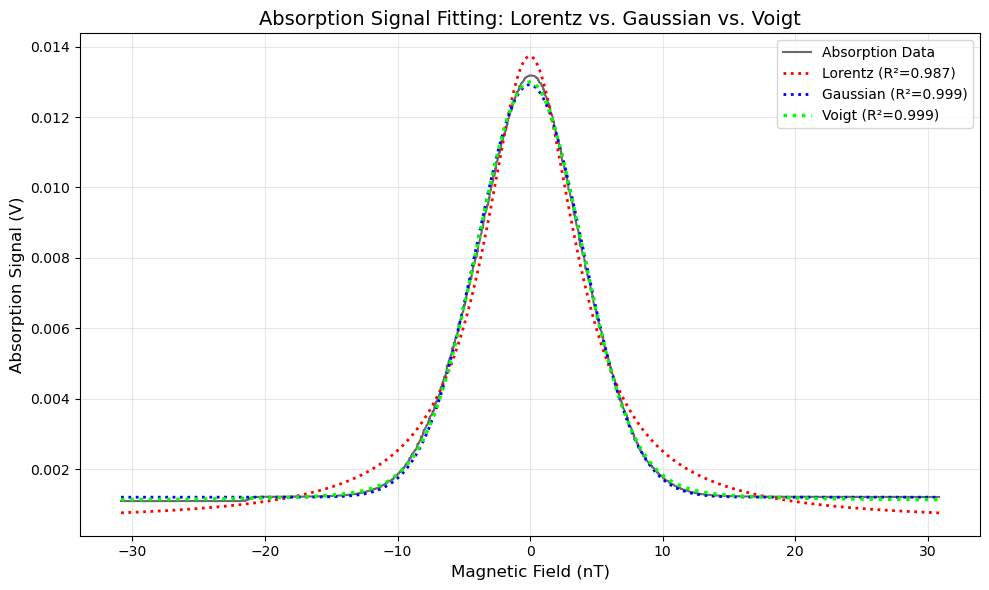


=== Detailed Voigt Fit Parameters ===
Amplitude: 0.1257
Center:    -0.0374 nT
Sigma:     3.6633 nT  (Gaussian width)
Gamma:     0.6742 nT  (Lorentzian width)
Offset:    0.001104
FWHM_G:    8.6271 nT  (Gaussian contribution)
FWHM_L:    1.3484 nT  (Lorentzian contribution)
FWHM:      9.3701 nT  (Total, Olivero-Longbothum)


In [5]:
# === Fits: Lorentz, Gaussian, Voigt ===
# Use automatic initialization (robust). If you want manual seeds, pass p0 dicts.
lorentz_result = lorentz_fit(data_ab)             # e.g., p0={"center": 0.0, "FWHM": 10}
gauss_result   = gauss_fit(data_ab)               # e.g., p0={"center": 0.0, "sigma": 5}
voigt_result   = voigt_fit(data_ab)               # e.g., p0={"center": 0.0, "sigma": 5, "gamma": 5}

# Print summaries
print(f"Lorentzian Fit — FWHM: {lorentz_result['FWHM']:.2f} nT, R²: {lorentz_result['R2']:.4f}")
print(f"Gaussian   Fit — FWHM: {gauss_result['FWHM']:.2f} nT, R²: {gauss_result['R2']:.4f}")

# New voigt_result has additional information
print(
    "Voigt      Fit — "
    f"FWHM: {voigt_result['FWHM']:.2f} nT, "
    f"σ: {voigt_result['sigma']:.2f} nT, γ: {voigt_result['gamma']:.2f} nT, "
    f"R²: {voigt_result['R2']:.4f}"
)

# Optional: Print model selection results
print(f"\n=== Model Comparison (AIC/BIC) ===")
print(f"Gaussian   — AIC: {voigt_result['AIC_BIC']['AIC']['G']:.2f}, BIC: {voigt_result['AIC_BIC']['BIC']['G']:.2f}")
print(f"Lorentzian — AIC: {voigt_result['AIC_BIC']['AIC']['L']:.2f}, BIC: {voigt_result['AIC_BIC']['BIC']['L']:.2f}")
print(f"Voigt      — AIC: {voigt_result['AIC_BIC']['AIC']['V']:.2f}, BIC: {voigt_result['AIC_BIC']['BIC']['V']:.2f}")
print(f"Best Model (by AIC): {voigt_result['ModelSelected']}")

# === Plot ===
plt.figure(figsize=(10, 6))
plt.plot(data_ab[:, 0], data_ab[:, 1], color='dimgray', linestyle='-', linewidth=1.5, 
         label='Absorption Data', zorder=1)

# Plot individual model fits from voigt_result
plt.plot(data_ab[:, 0], voigt_result['Data']['Lorentz_fit'], color='r', linestyle=':', lw=2,
         label=f'Lorentz (R²={voigt_result["Lorentzian"]["R2"]:.3f})', zorder=2)
plt.plot(data_ab[:, 0], voigt_result['Data']['Gauss_fit'], color='b', linestyle=':', lw=2,
         label=f'Gaussian (R²={voigt_result["Gaussian"]["R2"]:.3f})', zorder=3)
plt.plot(data_ab[:, 0], voigt_result['Data']['Voigt_fit'], color='lime', linestyle=':', lw=2.5,
         label=f'Voigt (R²={voigt_result["Voigt"]["R2"]:.3f})', zorder=4)

plt.xlabel("Magnetic Field (nT)", fontsize=12)
plt.ylabel("Absorption Signal (V)", fontsize=12)
plt.title("Absorption Signal Fitting: Lorentz vs. Gaussian vs. Voigt", fontsize=14)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# === Optional: Detailed Voigt Parameters ===
print(f"\n=== Detailed Voigt Fit Parameters ===")
voigt_params = voigt_result['Voigt']['Params']
print(f"Amplitude: {voigt_params['amplitude']:.4f}")
print(f"Center:    {voigt_params['center']:.4f} nT")
print(f"Sigma:     {voigt_params['sigma']:.4f} nT  (Gaussian width)")
print(f"Gamma:     {voigt_params['gamma']:.4f} nT  (Lorentzian width)")
print(f"Offset:    {voigt_params['offset']:.6f}")
print(f"FWHM_G:    {voigt_result['Voigt']['FWHM_G']:.4f} nT  (Gaussian contribution)")
print(f"FWHM_L:    {voigt_result['Voigt']['FWHM_L']:.4f} nT  (Lorentzian contribution)")
print(f"FWHM:      {voigt_result['Voigt']['FWHM']:.4f} nT  (Total, Olivero-Longbothum)")

## Dispersion Signal Fitting (Model-Based)

In low-field OPMs, the **demodulated** response is well described by a dispersion-like line shape.  
We recommend a **physics-based fit** and then deriving the **local slope** and **linear operating range** directly from the model.

---

### Model

We fit the demodulated signal with a centered dispersion model:
$$
f(B)=\frac{a\,b\,(B-\mathrm{center})}{1+\big[b\,(B-\mathrm{center})\big]^2}+c
$$

The **slope at resonance** (useful for sensitivity or calibration) is
$$
\left.\frac{df}{dB}\right|_{B=\mathrm{center}} = a\,b \;\equiv\; \text{Slope}.
$$

Define the **linear operating range** by the small-signal criterion
$$
\big(b(B-\mathrm{center})\big)^2 < \texttt{max\_rel\_err},
$$
which gives
$$
B \in \Big[\;\mathrm{center}-\frac{\sqrt{\texttt{max\_rel\_err}}}{|b|}\;,\;
             \mathrm{center}+\frac{\sqrt{\texttt{max\_rel\_err}}}{|b|}\;\Big]
\;\equiv\; \text{LinearRange}.
$$

> Typical choices: `max_rel_err = 0.01` (≈1% nonlinearity) or `0.04` (≈4%).

---

### Function

- **`dispersion_lorentz_fit(data, p0=None, bounds=None, max_rel_err=0.01, center_hint=None, smooth_win=9, robust_iters=1, mad_thresh=4.0)`**

**Inputs**
- `data`: DataFrame with `['B','S']` or `['B','demod']` (mapped internally),  
  or ndarray of shape `(N, 2)` as `[B, S]`.
- `p0` (optional): dict of initial guesses. Keys:
  - `amplitude` (`a`), `center`, `offset` (`c`), and **one of** `b` **or** `gamma` **or** `FWHM`.  
    Conversions:
    $$
    \gamma=\frac{1}{|b|}, \qquad \mathrm{FWHM}=\frac{2}{|b|}.
    $$
- `bounds` (optional): dict of `(min, max)` per parameter. You may bound `b` directly,
  or specify `gamma`/`FWHM` bounds which are internally converted into consistent limits on `b`.
- `max_rel_err` (optional): threshold used to compute `LinearRange` as above.
- `center_hint` (optional): preferred resonance center (e.g., `0.0`). The seed chooses the **zero-crossing closest to this value**.
- `smooth_win` (optional): moving-average window (in samples) applied **only during seeding** to suppress noise; disable with `<=1`.
- `robust_iters` (optional): number of **robust re-fits** with MAD-based outlier rejection (0/1/2…).
- `mad_thresh` (optional): rejection threshold in units of robust sigma (`1.4826*MAD`).

**Returns (unified format)**
- `out`: optimizer result (parameters/covariance)
- `S_fit`: fitted values on the input `B`
- `Params`: `{'amplitude','b','center','offset','gamma','slope'}`
- `FWHM`: $2/|b|$
- `sigma`: `None` (not applicable for this model)
- `gamma`: $1/|b|$
- `Data`: input data with an added `S_fit` column
- `R2`: coefficient of determination
- **`Slope`**: $a\,b$ at `center`
- **`LinearRange`**: $(B_{\min}, B_{\max})$ from `max_rel_err`
- `FitResult`: callable `f(B)` using the fitted parameters

---

### Practical guidance

- Always feed a **clean half-cycle** (rising or falling) cut so that `B` is monotonic (see `one_cycle_cut`).
- If the center drifts due to noise/outliers, use:
  - `center_hint=0.0` and/or `bounds={'center':(-5, 5)}`,
  - a modest `smooth_win` (e.g., `9–15`) to stabilize the seed,
  - `robust_iters=1` (or `2`) with `mad_thresh≈4.0` to suppress outliers.
- For sensitivity reporting, include both **`Slope`** and the chosen **`LinearRange`**.


Dispersion Fit — R²: 0.7568
Center: 0.064 nT
FWHM: 4.247 nT,  γ: 2.123 nT
Slope @ center: 1.6554 mV/nT
LinearRange (max_rel_err=0.01): [-0.148, 0.276] nT


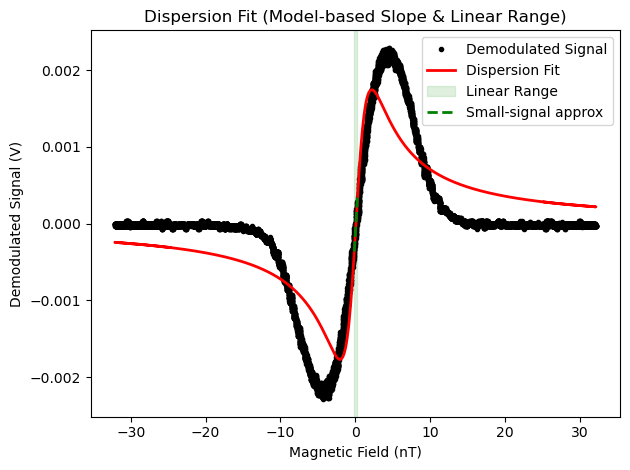

In [5]:
# --- Dispersion fit on the full (half-cycle) sweep ---
# data_demod is shape (N,2): [B, S], e.g. from:
# data_demod = np.column_stack((B, DemodCut))

disp_result = dispersion_lorentz_fit(
    data_demod,
    p0=None,                 # or e.g. {'center': 0.0, 'gamma': 5.0, 'amplitude': 1e-3}
    bounds=None,             # or dict bounds per your needs
    max_rel_err=0.01,         # ≈1% nonlinearity criterion for LinearRange
    center_hint=0.0
)

# --- Unpack fitted parameters and derived metrics ---
p      = disp_result["Params"]            # {'amplitude','b','center','offset'}
slope  = p["amplitude"] * p["b"]          # df/dB @ center
center = p["center"]
FWHM   = disp_result["FWHM"]
gamma  = disp_result["gamma"]
R2     = disp_result["R2"]
lin_lo, lin_hi = disp_result["LinearRange"]

print(f"Dispersion Fit — R²: {R2:.4f}")
print(f"Center: {center:.3f} nT")
print(f"FWHM: {FWHM:.3f} nT,  γ: {gamma:.3f} nT")
print(f"Slope @ center: {slope*1e3:.4f} mV/nT")  # V/nT → mV/nT
print(f"LinearRange (max_rel_err=0.01): [{lin_lo:.3f}, {lin_hi:.3f}] nT")

# --- Plot: full range with model fit, shaded LinearRange, and small-signal line ---
import matplotlib.pyplot as plt
plt.figure()

# raw demod data
plt.plot(data_demod[:, 0], data_demod[:, 1], 'k.', label='Demodulated Signal')

# model fit (aligned to input grid)
plt.plot(data_demod[:, 0], disp_result['Data']['S_fit'], 'r-', lw=2, label='Dispersion Fit')

# shaded linear operating range
plt.axvspan(lin_lo, lin_hi, color='tab:green', alpha=0.15, label='Linear Range')

# small-signal linearization about center: y ≈ c + slope·(B - center)
B_lin = np.linspace(lin_lo, lin_hi, 200)
y_lin = p["offset"] + slope*(B_lin - center)
plt.plot(B_lin, y_lin, 'g--', lw=2, label='Small-signal approx')

plt.xlabel("Magnetic Field (nT)")
plt.ylabel("Demodulated Signal (V)")
plt.title("Dispersion Fit (Model-based Slope & Linear Range)")
plt.legend()
plt.tight_layout()
plt.show()

> **Important:** Fitting over the **entire sweep** can degrade accuracy because the analytical
> dispersion model is only valid in the **low-field** regime where the SERF condition
> $ \omega_L \ll 1/\tau $ holds.
---
### Fit only the low-field portion

To obtain reliable parameters, restrict the fit to a neighborhood of the resonance:

- Choose a symmetric window around the center,
  $$
  |B-\mathrm{center}| \le \Delta B,
  $$
  with one of the following practical rules:
  - **Small-signal rule (recommended):**  
    $\Delta B = \sqrt{\texttt{max\_rel\_err}}/|b|$.  
    This is consistent with the linear-range definition used for reporting.
  - **Width-based rule:**  
    $\Delta B = \alpha/|b|$ with $\alpha \in [0.5,\,2]$.  
    Typical choices: $\alpha=1$ (i.e., $|B-\mathrm{center}| \le \gamma$) or  
    $\alpha=\sqrt{2}$ (roughly half of the Voigt/Lorentz FWHM equivalence).

- If the center is not known a priori, do a **two-stage procedure**:
  1) Perform a coarse fit with broad bounds (or give `center_hint`) to estimate `center` and `b`.  
  2) Build a mask using a rule above and **refit** only the masked region.

- When the data are noisy or contain turn-around artifacts, use the robust options in the fitter:
  `smooth_win` for seeding and `robust_iters`/`mad_thresh` for outlier rejection.

> In the next example we demonstrate a restricted fit by masking \(B\) to a low-field window
> around the fitted center and then refitting. This yields stable estimates for
> **Slope**, **gamma/FWHM**, and **LinearRange**.


Dispersion Fit (low-field window) R² = 0.9961
Center (nT)             = 0.1103
Slope @ center (a*b)   = 0.917085 mV/nT
gamma = 1/|b| (nT)      = 4.8328
FWHM = 2/|b| (nT)       = 9.6656
LinearRange (nT)        = [-0.3730, 0.5936]


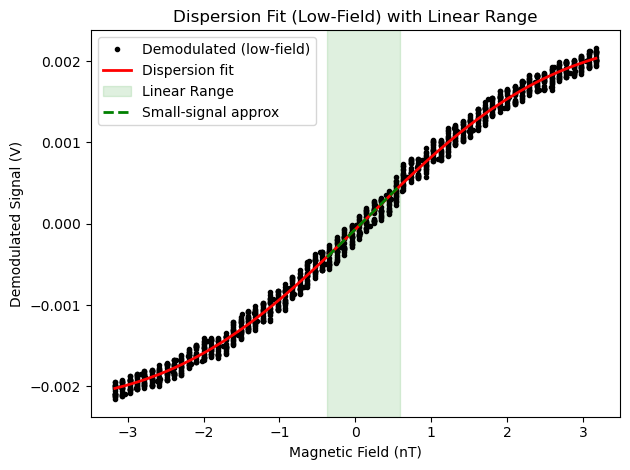

In [6]:
# --- Dispersion fit with a simple fixed low-field window + linear guides ---

# Choose a low-field window (center and half-width, both in nT)
center    = 0.0      # expected resonance center (e.g., 0.0)
widthratio = 5      # use ±5 % like before

# 1) Mask data to the fixed window
ran_B = max(data_demod[:, 0])-min(data_demod[:, 0])
mask = (data_demod[:, 0] >= center - ran_B*widthratio/100.0) & (data_demod[:, 0] <= center + ran_B*widthratio/100.0)
data_demod_focus = data_demod[mask]

# 2) Fit dispersion model on the masked region (give center as a light hint)
disp_result_focus = dispersion_lorentz_fit(
    data_demod_focus,
    p0={'center': center, 'amplitude': 0.01},
    max_rel_err=0.01  # used only for reporting LinearRange
)

# 3) Get linear-range bounds and linear approximation
ctr   = disp_result_focus['Params']['center']
slope = disp_result_focus['Slope']               # a*b
c0    = disp_result_focus['Params']['offset']    # f(center) = c
Bmin, Bmax = disp_result_focus['LinearRange']    # from max_rel_err and fitted b

# Build a straight-line approximation over the linear range:
B_lin  = np.linspace(Bmin, Bmax, 200)
S_lin  = c0 + slope*(B_lin - ctr)

# 4) Report
print("Dispersion Fit (low-field window) R² =", f"{disp_result_focus['R2']:.4f}")
print("Center (nT)             =", f"{ctr:.4f}")
print("Slope @ center (a*b)   =", f"{slope*1e3:.6g}", "mV/nT")
print("gamma = 1/|b| (nT)      =", f"{disp_result_focus['gamma']:.4f}")
print("FWHM = 2/|b| (nT)       =", f"{disp_result_focus['FWHM']:.4f}")
print("LinearRange (nT)        =", f"[{Bmin:.4f}, {Bmax:.4f}]")

# 5) Plot (focused data + model fit + linear guides)
p       = disp_result_focus['Params']
center  = p['center']
slope   = disp_result_focus['Slope']
lin_lo, lin_hi = disp_result_focus['LinearRange']

plt.figure()
plt.plot(data_demod_focus[:, 0], data_demod_focus[:, 1], 'k.', label='Demodulated (low-field)')
plt.plot(
    data_demod_focus[:, 0],
    disp_result_focus['Data']['S_fit'],
    'r-', lw=2, label='Dispersion fit'
)

# shaded linear range
plt.axvspan(lin_lo, lin_hi, color='tab:green', alpha=0.15, label='Linear Range')

# small-signal linearization about center: y ≈ c + slope·(B - center)
B_lin = np.linspace(lin_lo, lin_hi, 200)
y_lin = p["offset"] + slope*(B_lin - center)
plt.plot(B_lin, y_lin, 'g--', lw=2, label='Small-signal approx')

plt.xlabel("Magnetic Field (nT)")
plt.ylabel("Demodulated Signal (V)")
plt.title("Dispersion Fit (Low-Field) with Linear Range")
plt.legend()
plt.tight_layout()
plt.show()

### Noise Analysis: Full-range Power Spectral Density (PSD)

To obtain an overview of the spectral characteristics of the OPM system, we first compute the **full-range PSD** of the **demodulated** signal. This gives a wideband picture of both electronic and optical noise contributions up to the Nyquist frequency.

We use the function **`noise_psd(data, band=(0, Nyquist), window='hann', average='median')`**, which implements a **Welch PSD** with defaults optimized for noise analysis:

- **Window:** `hann` (good resolution, low leakage)
- **Averaging:** `median` (robust against narrow spurs/outliers)
- **Segment sizing:** auto-adjusted to balance frequency resolution vs. number of segments

#### What it returns

`pts, mean_rms, fs, info = noise_psd(...)`

- **`pts`**: two-column array `[f, PSD]` with PSD in **V²/Hz** (Welch estimate)  
- **`mean_rms`**: mean **ASD** across the selected band (here the full Nyquist range), i.e.  
  \\( \sqrt{\mathrm{mean}(\mathrm{PSD})} \\), in **V/√Hz**  
- **`fs`**: sampling frequency inferred from the time axis (Hz)  
- **`info`**: diagnostic dict  
  `{'nperseg','noverlap','n_segments','df','window','average','band_bins','band_range'}`

#### Limitations of full-range analysis

When the raw sampling rate is high (e.g., ~5 kHz) but the **band of interest is low-frequency (3–80 Hz)**, the automatic segment length becomes short to maintain enough averages.  
This leads to a **coarse frequency resolution** (tens of Hz per bin), which can **severely underestimate low-frequency ASD**.  
Thus, while full-range PSD is useful for a **broad noise overview**, it is **not reliable for quantitative sensitivity estimates in the low-frequency band**.

#### Measurement conditions (important)

Record “noise-only” data:

- **Disable** DC bias field and **disable** external **triangle sweep** modulation.
- **Keep the lock-in reference ON** (internal modulation stays active), since the demodulated channel is analyzed.
- Keep only the detection chain active (laser, LIA, PD, etc.) so the spectrum reflects **intrinsic electronic/optical noise**.

#### Window choices (quick guidance)

- **`hann` + `median`** (default): best general choice for noise-floor estimation.
- **`flattop` + `mean`**: for accurate single-tone amplitude calibration.
- **`blackmanharris` + `median`**: for high dynamic range, very low sidelobes.

#### Example usage

Compute the full-range PSD (0–Nyquist ≈ 2500 Hz) to visualize noise peaks and overall noise floor distribution:

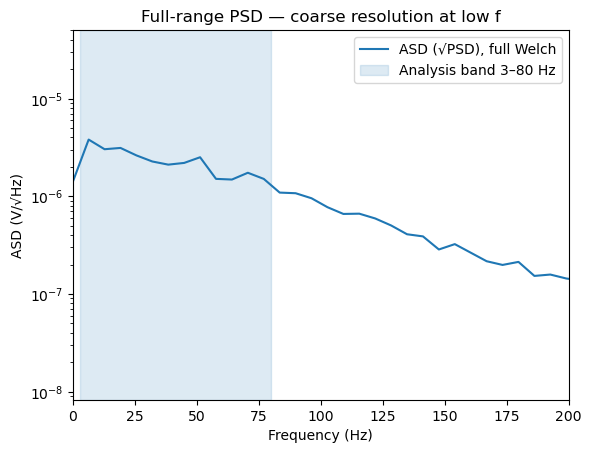

=== Welch full overview ===
fs: 5122.4 Hz, df(bin): 6.4191 Hz, segments: 39
Mean ASD over 3–80 Hz: 2.428e+00 uV/√Hz


In [7]:
# === PSD overview (full record) ===
pts_full, mean_asd_full, fs, info_full = noise_psd(
    data=noisedata,
    band=(3.0, 80.0),
    window='hann',
    average='median',
    detrend='linear'
)

f_full, Pxx_full = pts_full[:, 0], pts_full[:, 1]

plt.figure()
plt.semilogy(f_full, np.sqrt(Pxx_full), label='ASD (√PSD), full Welch')
plt.axvspan(3.0, 80.0, color='tab:blue', alpha=0.15, label='Analysis band 3–80 Hz')
plt.xlabel('Frequency (Hz)')
plt.ylabel('ASD (V/√Hz)')
plt.title('Full-range PSD — coarse resolution at low f')
plt.xlim(0,200)
plt.legend()
plt.show()

print("=== Welch full overview ===")
print(f"fs: {fs:.1f} Hz, df(bin): {info_full['df']:.4f} Hz, "
      f"segments: {info_full['n_segments']}")
print(f"Mean ASD over 3–80 Hz: {mean_asd_full*1e6:.3e} uV/√Hz")

>⚠️ For quantitative sensitivity evaluation in the 3–80 Hz band, use the low-band PSD function (noise_psd_lowband) with automatic downsampling.

### Noise Analysis: Low-band PSD with Resolution Enhancement

For accurate evaluation of the OPM sensitivity in the **biologically relevant low-frequency band (3–80 Hz)**, we employ a dedicated **low-band PSD** function.  
Unlike the full-range Welch, which is limited by coarse bin spacing at high sampling rates, this method automatically performs **anti-alias filtering** and **downsampling** when the raw sampling rate is excessive (e.g., ~5 kHz).  
The result is a PSD with **fine frequency resolution (≤1 Hz/bin)** and enough statistical averaging, ensuring reliable estimates in the low-frequency regime.

We use **`noise_psd_lowband(data, band=(f1,f2))`**, which wraps around `noise_psd` with low-frequency–friendly defaults:

- **Window:** `hann` (good resolution, low leakage)
- **Averaging:** `median` (robust against narrow spurs/outliers)
- **Detrend:** `linear` (suppress slow drifts)
- **Auto preprocessing:** if `band_hi ≤ 150 Hz` and raw `fs` is much higher than needed,  
  → apply FIR low-pass + rational resampling to ~4–6×band_hi (typically 400–500 Hz for 3–80 Hz analysis)

#### What it returns

`pts, mean_rms, fs, info = noise_psd_lowband(...)`

- **`pts`**: two-column array `[f, PSD]` with PSD in **V²/Hz**  
- **`mean_rms`**: mean **ASD** over the chosen band (e.g., 3–80 Hz), in **V/√Hz**  
- **`fs`**: effective sampling rate after preprocessing (Hz)  
- **`info`**: diagnostic dict, with preprocessing details  
  `{'preprocessed','fs_raw','fs_target','fs_used','lp_cutoff','nperseg','n_segments','df','band_range'}`

#### Advantages

- **Fine frequency resolution:** sub-Hz bins even with short (3–8 s) records  
- **Robust averaging:** maintains ≥4–5 Welch segments when possible  
- **Reliable low-frequency ASD:** avoids severe underestimation seen in full-range PSD  
- **Automatic workflow:** preprocessing triggered only when necessary (band_hi ≤ 150 Hz, fs high)

#### Example usage

Analyze the **3–80 Hz band**:

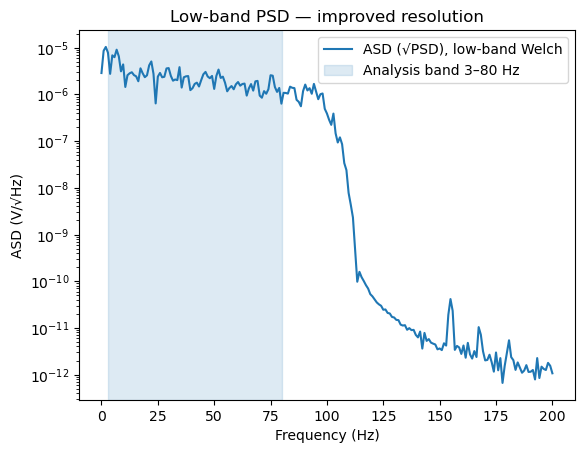

=== Welch low-band (3–80 Hz) ===
fs: 400.0 Hz, df(bin): 0.9615 Hz, segments: 5
Mean ASD over 3–80 Hz: 2.797e+00 uV/√Hz


In [8]:
# === Low-frequency analysis (3–80 Hz) ===
pts, asd_mean, fs_used, info = noise_psd_lowband(
    data=noisedata,
    band=(3.0, 80.0)   
)

f_b, Pxx_b = pts[:, 0], pts[:, 1]

plt.figure()
plt.semilogy(f_b, np.sqrt(Pxx_b), label='ASD (√PSD), low-band Welch')
plt.axvspan(3.0, 80.0, color='tab:blue', alpha=0.15, label='Analysis band 3–80 Hz')
plt.xlabel('Frequency (Hz)')
plt.ylabel('ASD (V/√Hz)')
plt.title('Low-band PSD — improved resolution')
plt.legend()
plt.show()

print("=== Welch low-band (3–80 Hz) ===")
print(f"fs: {fs_used:.1f} Hz, df(bin): {info['df']:.4f} Hz, "f"segments: {info['n_segments']}")
print(f"Mean ASD over 3–80 Hz: {asd_mean*1e6:.3e} uV/√Hz")

>✅ This approach provides trustworthy sensitivity estimates in the 3–80 Hz band,
while full-range Welch (0–Nyquist) should only be used for a broad overview of spectral content.

## Estimate Sensitivity of OPM System

The magnetic-field sensitivity is estimated as
$$
\eta \;=\; \frac{V_{\mathrm{noise}}}{\bigl|\partial V / \partial B\bigr|} \quad \text{(nT/√Hz)}
$$

where:
- $V_{\mathrm{noise}}$: RMS noise spectral density near the modulation frequency (V/√Hz)
- $\partial V/\partial B$: signal slope around zero field (V/nT)

---

### Procedure (model-based)

1. **Slope near $B \approx 0$**  
   Fit the demodulated signal in a **low-field window** with  
   **`dispersion_lorentz_fit`** and read out **`Slope = a·b`** (units: V/nT).

2. **Noise ASD from a separate noise file**  
   Use **`noise_psd(noise_df, targetf, half_bw, window='hann', average='median')`**  
   to obtain the **mean ASD** (V/√Hz) around your modulation frequency.

3. **Sensitivity**  
   $ \eta \,[\mathrm{nT}/\sqrt{\mathrm{Hz}}] \;=\; \dfrac{\mathrm{ASD}\,[\mathrm{V}/\sqrt{\mathrm{Hz}}]}{|\mathrm{Slope}|\,[\mathrm{V}/\mathrm{nT}]} $.

---

### Notes
- Ensure the **B axis is in nT** before fitting; otherwise convert units.
- Use a **clean half-cycle** and limit the fit to a **low-field region** where the model is valid.
- Record noise with **DC bias OFF** and **triangle sweep OFF**; keep the **LIA reference ON**.
- Choose a narrow band (e.g., ±1–2 Hz) around the modulation frequency to avoid spurs/harmonics.
"""

In [9]:
#Slope:V/nT; noise:V/√Hz
sensitivity = abs(asd_mean / slope)*1e3                # pT/√Hz
print(f"Estimated sensitivity = {sensitivity:.3f} pT/√Hz")

Estimated sensitivity = 3.050 pT/√Hz


#### Remarks
This estimate represents the **best achievable sensitivity near DC**.

If the system is limited by environmental or technical noise (e.g., optical or electronics), this analysis helps locate the bottleneck.
